**Theory Questions:**

*Q1: Why is the KL Divergence term important in the VAE loss function?*

KL divergence tracks how far away the distribution produced by the encoder is from a fixed prior, and learning to minimize this ensures that every input results in a latent distribution close to a standard normal. Without it, image features would each learn a compressed encoding, but they would not have this emergent propety of self-arranging to a like-near-like space that works well for image prediction. This nearness principle is what allows image "generation" where the model can predict an image from the space. Without optimizing KL divergence, the model learns to be accurate on its training data, but does not produce a continous space where similar inputs relate to similar distributions (instead, the learned reconstructions live in independent pockets of latent space and have no guarantee of likeness to the distributions learned all around them). KL is like a regularization against memorized optimization of the reconstruction loss term, forcing the model to learn to reconstruct only as well as it can while keeping all encodings in a single dense distribution.

*Q2: How does the reparameterization trick enable backpropagation through the stochastic
layers of a VAE?*

Since sampling is stochastic, there is by definition not a function to capture its change with respect to its layer. Backpropogation wants to distribute the update through each layer as a weighted factor of the contribution of each perceptron node, so random sampling doesn't provide a way to determine this. The reparameterization rewrites the sample as a (deterministic) factor of the mean and std deviation, with the "randomness" factored out as a separate distribution independent of the network. This allows a fully differentiably calculation to be learned from loss to the mean and stdDev through the sample.

*Q3: Why does a VAE use a probabilistic latent space instead of a fixed latent space?*

The goal is to generate new data. Related to above Q1 response, if we do *not* learn a probability distribution for each input, then we'd only be compressing the data and predicting back to the learned inflation. By learning the way that probablity is distributed across the space, the samples produced in the generation are based upon likely values within the learned distribution rather than likely values that exactly corresponded to the original data. The emergent result is that new generated data follows observed patterns of properties and stays within the range or probable variations, but is unlikely to produce the actual original.

*Q4: What role does KL Divergence play in ensuring a smooth latent space?*

I feel like this is basically also why the term is important to the loss function? It prevents the encodings from becoming islands. Since the KL term penalizes how far the distribution of q(z | x) = N(mu(x), sigma(x)^2) deviates from a fixed prior, all distributions have to "try" to stay within the same area of latent space and find their best spot. Without it, distributions could find unique space easily by moving far away, and distributions that ought to overlap might never find each other.

I'm leaving the part below alone for reference; this is the fully-connected achitecture we were given. Tasks for Assignment 3 appear further down.

In [ ]:
#!pip install torch
#!pip install torchvision

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# VAE Architecture
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [ ]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [ ]:
# Training the VAE
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

In [ ]:
# Load MNIST dataset and run the training
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

vae = VAE(input_dim=784, hidden_dim=400, latent_dim=20)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(1, 11):
    train(vae, train_loader, optimizer, epoch)


Epoch 1, Loss: 164.3328459798177
Epoch 2, Loss: 121.90541365559896
Epoch 3, Loss: 114.77928165690105
Epoch 4, Loss: 111.82207796223959
Epoch 5, Loss: 110.08858608398438
Epoch 6, Loss: 108.91394490559895
Epoch 7, Loss: 108.10610126953125
Epoch 8, Loss: 107.51861396484375
Epoch 9, Loss: 107.03786321614584
Epoch 10, Loss: 106.58468134765624


In [ ]:
import matplotlib.pyplot as plt

# Function to generate and display new images
def generate_images(model, num_images=10, latent_dim=20):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim)
        # Decode these points to generate images
        generated_images = model.decode(z).cpu()

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].view(28, 28), cmap='gray')
        axs[i].axis('off')
    plt.show()




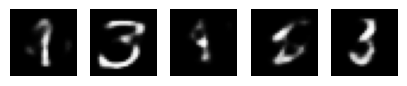

In [ ]:
# Assuming you have already trained the model (vae) and it has a latent dimension of 20
generate_images(vae, num_images=5, latent_dim=20)

**2. Coding Tasks:**

Task 1: Modify the VAE architecture to use convolutional layers for both the encoder and decoder, and
train it on the CIFAR-10 dataset.

Using device: cuda
Files already downloaded and verified
Training Convolutional VAE on CIFAR-10
Epoch 1, Loss: 1919.7080, Beta: 0.100
Epoch 2, Loss: 1838.3076, Beta: 0.200
Epoch 3, Loss: 1820.6985, Beta: 0.300
Epoch 4, Loss: 1814.5768, Beta: 0.400
Epoch 5, Loss: 1813.4904, Beta: 0.500
Epoch 6, Loss: 1814.0861, Beta: 0.600
Epoch 7, Loss: 1816.0620, Beta: 0.700
Epoch 8, Loss: 1818.5270, Beta: 0.800
Epoch 9, Loss: 1821.3966, Beta: 0.900
Epoch 10, Loss: 1824.3154, Beta: 1.000
Epoch 11, Loss: 1823.7895, Beta: 1.000
Epoch 12, Loss: 1822.9461, Beta: 1.000
Epoch 13, Loss: 1822.6238, Beta: 1.000
Epoch 14, Loss: 1822.1050, Beta: 1.000
Epoch 15, Loss: 1821.5267, Beta: 1.000
Epoch 16, Loss: 1821.3457, Beta: 1.000
Epoch 17, Loss: 1820.9708, Beta: 1.000
Epoch 18, Loss: 1820.3636, Beta: 1.000
Epoch 19, Loss: 1820.0825, Beta: 1.000
Epoch 20, Loss: 1819.9270, Beta: 1.000

Training Fully Connected VAE on CIFAR-10
Epoch 1, Loss: 1953.1914, Beta: 0.100
Epoch 2, Loss: 1901.8146, Beta: 0.200
Epoch 3, Loss: 

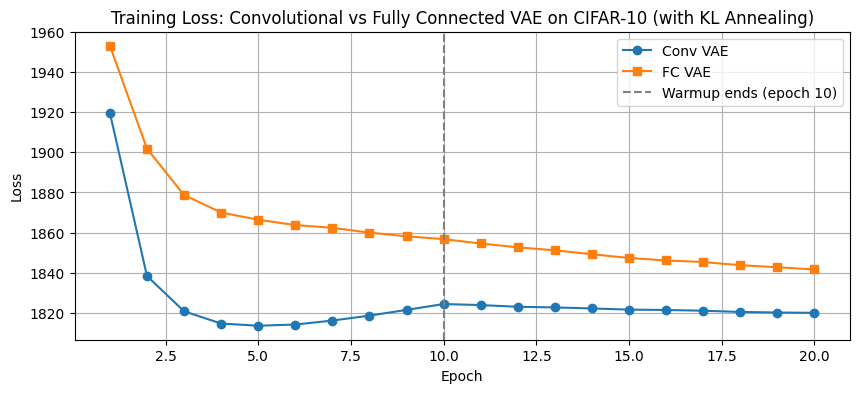

In [ ]:
# Convolutional VAE for CIFAR-10
# The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
# Ref: https://www.cs.toronto.edu/~kriz/cifar.html

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Convolutional VAE Architecture
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        # Build encoder conv layers
        # Input: 3 x 32 x 32 (RGB)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),   # -> 32 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # -> 64 x 8 x 8
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> 128 x 4 x 4
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),# -> 256 x 2 x 2
            nn.ReLU(),
        )

        # Latent space projections
        self.fc_mu = nn.Linear(256 * 2 * 2, latent_dim)
        self.fc_logvar = nn.Linear(256 * 2 * 2, latent_dim)

        # Decoder: Transposed conv layers to reconstruct images
        self.fc_decode = nn.Linear(latent_dim, 256 * 2 * 2)

        # Build decoder conv layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # -> 128 x 4 x 4
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> 64 x 8 x 8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # -> 32 x 16 x 16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # -> 3 x 32 x 32
            nn.Sigmoid(),  # Output pixels in [0, 1]
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten: batch x (256*2*2)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(h.size(0), 256, 2, 2)  # Reshape for conv layers
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Since we also need a fully connected VAE for comparison,
# this is basically the same as the reference but adapted for CIFAR-10 input size.
class FCVAE_CIFAR(nn.Module):
    def __init__(self, input_dim=3072, hidden_dim=1024, latent_dim=128):
        super(FCVAE_CIFAR, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 512)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        h = torch.relu(self.fc4(h))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        x_flat = x.view(x.size(0), -1)  # Flatten: batch x 3072
        mu, logvar = self.encode(x_flat)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Loss function
# MODIFIED! Now with KL annealing (beta-VAE warmup).
# The notes suggest this technique should be used to improve the
# results over a linnear KL of 1.
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction loss (BCE for pixel values in [0,1])
    BCE = nn.functional.binary_cross_entropy(recon_x.view(recon_x.size(0), -1),
                                              x.view(x.size(0), -1),
                                              reduction='sum')
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # KL annealing: gradually increase KLD weight from 0 to 1 during warmup
    return BCE + beta * KLD


# Training function with KL annealing
def train_vae(model, train_loader, optimizer, epoch, device, is_conv=True, warmup_epochs=10):
    model.train()
    train_loss = 0
    # New KL annealing: beta increases from 0 to 1 over warmup_epochs
    beta = min(1.0, epoch / warmup_epochs)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar, beta=beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Loss: {avg_loss:.4f}, Beta: {beta:.3f}')
    return avg_loss


# Set device (I'm on an Nvidia card locally, might need to comment out on Colab)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# CIFAR-10 class names for reference
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Initialize models
latent_dim = 128
conv_vae = ConvVAE(latent_dim=latent_dim).to(device)
fc_vae = FCVAE_CIFAR(latent_dim=latent_dim).to(device)

# Optimizers
conv_optimizer = optim.Adam(conv_vae.parameters(), lr=1e-3)
fc_optimizer = optim.Adam(fc_vae.parameters(), lr=1e-3)

# Train both models with KL annealing
num_epochs = 20
warmup_epochs = 10  # Beta reaches 1.0

print("Training Convolutional VAE on CIFAR-10")
conv_losses = []
for epoch in range(1, num_epochs + 1):
    loss = train_vae(conv_vae, train_loader, conv_optimizer, epoch, device, is_conv=True, warmup_epochs=warmup_epochs)
    conv_losses.append(loss)

print("\nTraining Fully Connected VAE on CIFAR-10")
fc_losses = []
for epoch in range(1, num_epochs + 1):
    loss = train_vae(fc_vae, train_loader, fc_optimizer, epoch, device, is_conv=False, warmup_epochs=warmup_epochs)
    fc_losses.append(loss)

# Plot training curves
plt.figure(figsize=(10, 4))
plt.plot(range(1, num_epochs + 1), conv_losses, label='Conv VAE', marker='o')
plt.plot(range(1, num_epochs + 1), fc_losses, label='FC VAE', marker='s')
plt.axvline(x=warmup_epochs, color='gray', linestyle='--', label=f'Warmup ends (epoch {warmup_epochs})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss: Convolutional vs Fully Connected VAE on CIFAR-10 (with KL Annealing)')
plt.legend()
plt.grid(True)
plt.show()

Convolution improved faster, and more overall! After adding a regularisation factor, the losses are:

- 1:  1822.1363 | 1850.7101 <- Unregulated, full KL weight at epoch 1
- 5:  1820.3351 | 1845.1653
- 10: 1819.9270 | 1841.5608

Regularization allows the model to learn reconstruction for a while before constraining itself to a dense and continuous geometry, but risks sparse areas of the distribution. Next, I'll examine images.

*After training, compare
the generated images with those from a fully connected VAE.*


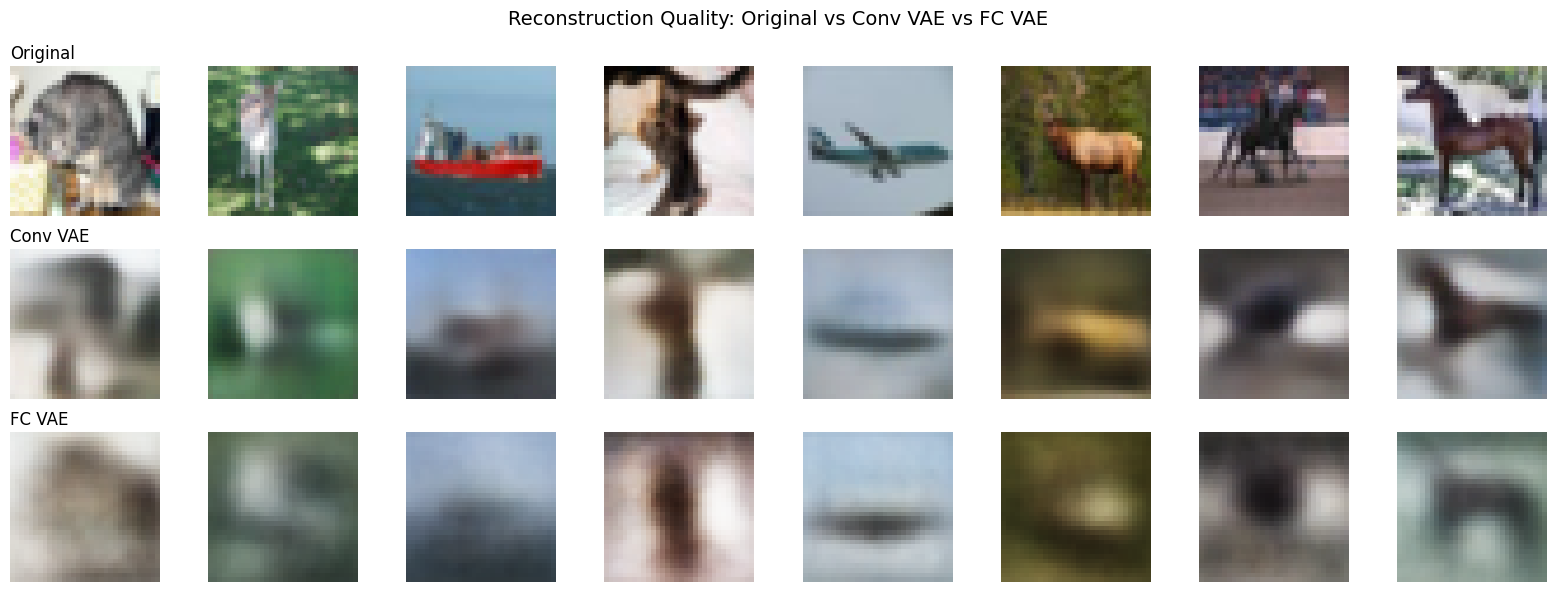

In [ ]:
# Generate some images from both, compare side by side, compare to data

def show_reconstructions(conv_model, fc_model, data_loader, num_images=8):
    """Compare reconstruction quality between models."""
    conv_model.eval()
    fc_model.eval()

    # Get a batch of real images
    real_images, _ = next(iter(data_loader))
    real_images = real_images[:num_images].to(device)

    with torch.no_grad():
        # Reconstruct with Conv VAE
        conv_recon, _, _ = conv_model(real_images)
        conv_recon = conv_recon.cpu()

        # Reconstruct with FC VAE
        fc_recon, _, _ = fc_model(real_images)
        fc_recon = fc_recon.cpu().view(-1, 3, 32, 32)

    real_images = real_images.cpu()

    # Create comparison figure
    fig, axes = plt.subplots(3, num_images, figsize=(num_images * 2, 6))

    for i in range(num_images):
        # Original images (top row)
        img_orig = real_images[i].permute(1, 2, 0).numpy()
        axes[0, i].imshow(np.clip(img_orig, 0, 1))
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=12, loc='left')

        # Conv VAE reconstructions (middle row)
        img_conv = conv_recon[i].permute(1, 2, 0).numpy()
        axes[1, i].imshow(np.clip(img_conv, 0, 1))
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Conv VAE', fontsize=12, loc='left')

        # FC VAE reconstructions (bottom row)
        img_fc = fc_recon[i].permute(1, 2, 0).numpy()
        axes[2, i].imshow(np.clip(img_fc, 0, 1))
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_title('FC VAE', fontsize=12, loc='left')

    plt.suptitle('Reconstruction Quality: Original vs Conv VAE vs FC VAE', fontsize=14)
    plt.tight_layout()
    plt.show()


# Compare reconstruction quality
show_reconstructions(conv_vae, fc_vae, train_loader, num_images=8)

# Re-run a few times to keep trying comparisons



The Convolutional model produces images that are consistently better contrast and preserve shapes. In particular, images where the subject is against a plain background with contrast in the original, the conv model is close enouth to actually resemble the thing itself. For images with camoflauged features, both images are hard to distinguish, but the convolutional model produces shapes that better represent the original.

**Task 2**: Using the trained VAE, interpolate between two images in the latent space and generate intermediate
images.

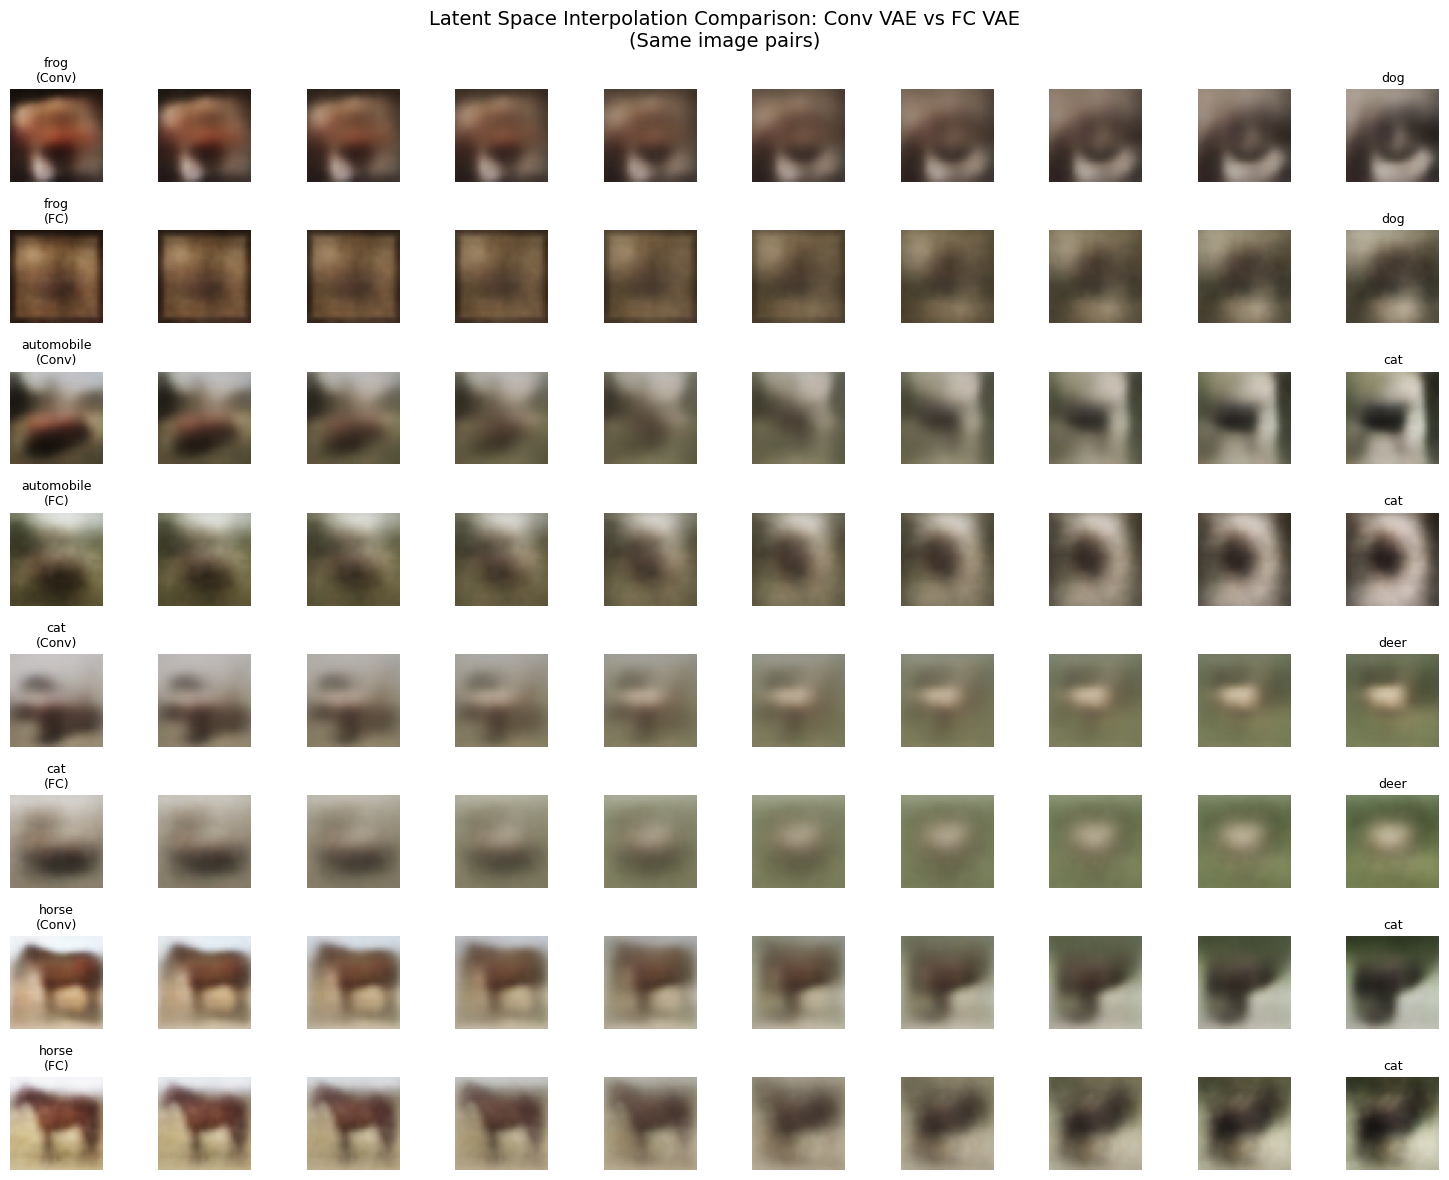

In [ ]:
def interpolate_images(model, img1, img2, num_steps=10, device='cpu', flatten=False):
    """
    Interpolate between two images in latent space.

    Args:
        model: Trained VAE model
        img1, img2: Input images (tensors of shape [C, H, W])
        num_steps: Number of interpolation steps
        device: Device to run on
        flatten: If True, flatten input before encoding (for FC models)

    Returns:
        List of interpolated images
    """
    model.eval()

    with torch.no_grad():
        # Add batch dimension and move to device
        img1 = img1.unsqueeze(0).to(device)
        img2 = img2.unsqueeze(0).to(device)

        # Flatten if needed (for FC models)
        if flatten:
            img1_enc = img1.view(img1.size(0), -1)
            img2_enc = img2.view(img2.size(0), -1)
        else:
            img1_enc = img1
            img2_enc = img2

        # Encode both images to get latent representations
        mu1, _ = model.encode(img1_enc)
        mu2, _ = model.encode(img2_enc)

        # Generate interpolation steps (linear interpolation)
        interpolated_images = []
        for alpha in np.linspace(0, 1, num_steps):
            # Linearly interpolate in latent space
            z_interp = (1 - alpha) * mu1 + alpha * mu2

            # Decode the interpolated latent vector
            img_interp = model.decode(z_interp)
            interpolated_images.append(img_interp.cpu())

    return interpolated_images


def compare_interpolations(conv_model, fc_model, data_loader, cifar10_classes,
                           num_pairs=3, num_steps=10, device='cpu'):
    """
    Compare interpolation between Conv VAE and FC VAE using the SAME image pairs.

    Args:
        conv_model: Trained Convolutional VAE model
        fc_model: Trained Fully Connected VAE model
        data_loader: DataLoader containing images
        cifar10_classes: List of class names for CIFAR-10
        num_pairs: Number of image pairs to interpolate
        num_steps: Number of interpolation steps per pair
        device: Device to run on
    """
    conv_model.eval()
    fc_model.eval()

    # Get a batch of images (same batch for both models)
    images, labels = next(iter(data_loader))

    # Create figure with 2 rows per pair (Conv VAE row, FC VAE row)
    fig, axes = plt.subplots(num_pairs * 2, num_steps,
                             figsize=(num_steps * 1.5, num_pairs * 3))

    for pair_idx in range(num_pairs):
        # Select two different images for this pair
        idx1 = pair_idx * 2
        idx2 = pair_idx * 2 + 1

        img1 = images[idx1]
        img2 = images[idx2]

        # Get class names for title
        class1 = cifar10_classes[labels[idx1]]
        class2 = cifar10_classes[labels[idx2]]

        # Interpolate with Conv VAE
        conv_interpolated = interpolate_images(conv_model, img1, img2, num_steps,
                                                device, flatten=False)

        # Interpolate with FC VAE (same images!)
        fc_interpolated = interpolate_images(fc_model, img1, img2, num_steps,
                                              device, flatten=True)

        # Row indices for this pair
        conv_row = pair_idx * 2
        fc_row = pair_idx * 2 + 1

        # Display Conv VAE interpolation
        for step_idx, img in enumerate(conv_interpolated):
            img_np = img.squeeze(0).permute(1, 2, 0).numpy()
            axes[conv_row, step_idx].imshow(np.clip(img_np, 0, 1))
            axes[conv_row, step_idx].axis('off')

            # Add labels
            if step_idx == 0:
                axes[conv_row, step_idx].set_title(f'{class1}\n(Conv)', fontsize=9)
            elif step_idx == num_steps - 1:
                axes[conv_row, step_idx].set_title(class2, fontsize=9)

        # Display FC VAE interpolation
        for step_idx, img in enumerate(fc_interpolated):
            img_np = img.view(3, 32, 32).permute(1, 2, 0).numpy()
            axes[fc_row, step_idx].imshow(np.clip(img_np, 0, 1))
            axes[fc_row, step_idx].axis('off')

            # Add labels
            if step_idx == 0:
                axes[fc_row, step_idx].set_title(f'{class1}\n(FC)', fontsize=9)
            elif step_idx == num_steps - 1:
                axes[fc_row, step_idx].set_title(class2, fontsize=9)

    plt.suptitle('Latent Space Interpolation Comparison: Conv VAE vs FC VAE\n(Same image pairs)',
                 fontsize=14)
    plt.tight_layout()
    plt.show()

compare_interpolations(conv_vae, fc_vae, train_loader, cifar10_classes,
                        num_pairs=4, num_steps=10, device=device)


**Task 3: Train the VAE on a new dataset of your choice**

A coworker just told me about PokeAPI last week--an API reference to the images of collectible monsters from the Pokemon games. I'm going to try to make a Pokemon transforming/generating VAE

POKEMON VAE - Multi-Sprite Data Loading
Loading sprites for 151 Pokemon...
  Pokemon 25/151: Pikachu - 70 sprites
  Pokemon 50/151: Diglett - 50 sprites
  Pokemon 75/151: Graveler - 50 sprites
  Pokemon 100/151: Voltorb - 50 sprites
  Pokemon 125/151: Electabuzz - 50 sprites
  Pokemon 150/151: Mewtwo - 50 sprites

Successfully loaded 7978 total sprites from 151 Pokemon!
Testing Pokemon #25):


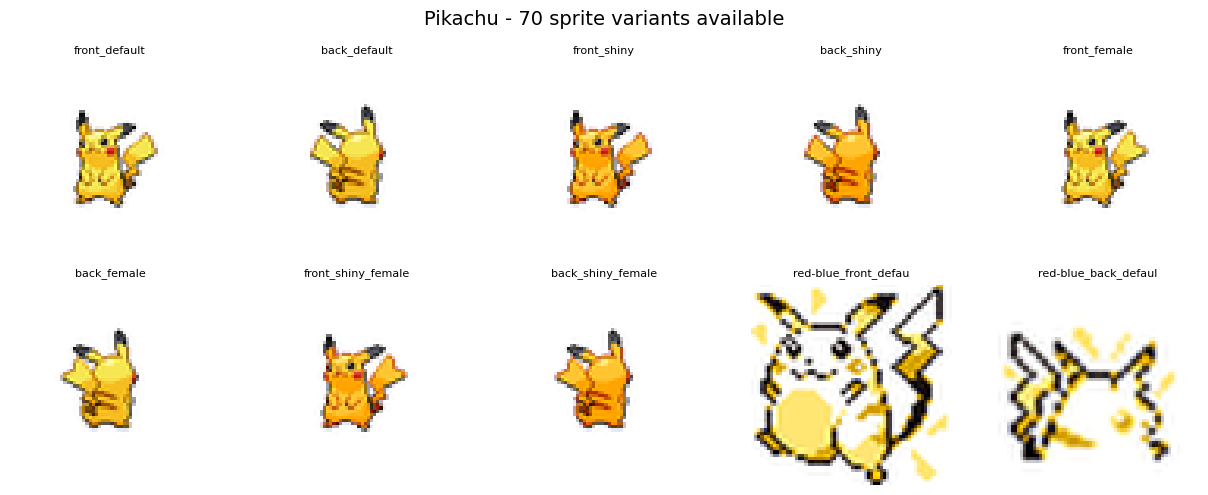

Random samples from dataset:


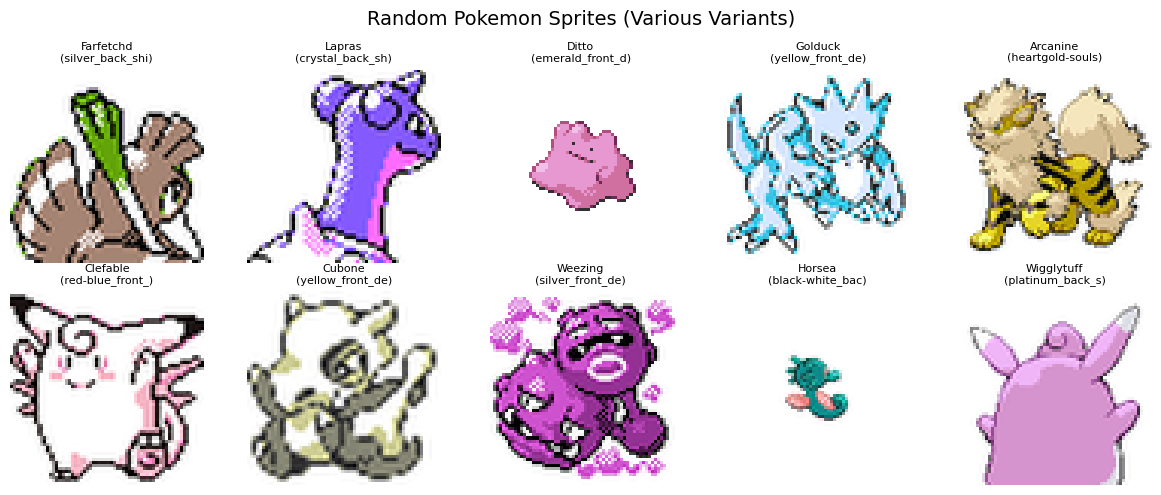

Dataset ready
  - Total sprites: 7978
  - Unique Pokemon: 151
  - Avg sprites per Pokemon: 52.83443708609271
  - Image size: 64x64


In [ ]:
# Data Loading
# This cell downloads multiple sprite variants per Pokemon for better training
#
# Some dataloading code and examples are reused from PokeAPI,
# and the images will be loaded from there.
# https://pokeapi.co/
#
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
from io import BytesIO

class PokemonMultiSpriteDataset(Dataset):
    """Dataset of Pokemon sprites"""

    # I've expanded this slightly, after discovering that:
    # 1) A single image for 151 Pokemon is not enough data to train a good VAE
    # 2) The API has images of front/back, "shiny", some "female" variants, and
    # there are pictures for multiple versions of the games.
    #
    # Tryring this now with a new cache, "pokemon_cache_multi" that includes as many images as I can.

    # All available sprite keys in PokeAPI
    SPRITE_KEYS = [
        # Standard sprites
        'front_default',
        'back_default',
        'front_shiny',
        'back_shiny',
        'front_female',
        'back_female',
        'front_shiny_female',
        'back_shiny_female',
    ]

    # Additional sprites from other game versions (nested under 'versions')
    VERSION_SPRITES = {
        'generation-i': {
            'red-blue': ['front_default', 'back_default', 'front_gray', 'back_gray'],
            'yellow': ['front_default', 'back_default', 'front_gray', 'back_gray'],
        },
        'generation-ii': {
            'crystal': ['front_default', 'back_default', 'front_shiny', 'back_shiny'],
            'gold': ['front_default', 'back_default', 'front_shiny', 'back_shiny'],
            'silver': ['front_default', 'back_default', 'front_shiny', 'back_shiny'],
        },
        'generation-iii': {
            'emerald': ['front_default', 'front_shiny'],
            'firered-leafgreen': ['front_default', 'back_default', 'front_shiny', 'back_shiny'],
            'ruby-sapphire': ['front_default', 'back_default', 'front_shiny', 'back_shiny'],
        },
        'generation-iv': {
            'diamond-pearl': ['front_default', 'back_default', 'front_shiny', 'back_shiny',
                             'front_female', 'back_female', 'front_shiny_female', 'back_shiny_female'],
            'heartgold-soulsilver': ['front_default', 'back_default', 'front_shiny', 'back_shiny',
                                     'front_female', 'back_female', 'front_shiny_female', 'back_shiny_female'],
            'platinum': ['front_default', 'back_default', 'front_shiny', 'back_shiny',
                        'front_female', 'back_female', 'front_shiny_female', 'back_shiny_female'],
        },
        'generation-v': {
            'black-white': ['front_default', 'back_default', 'front_shiny', 'back_shiny',
                           'front_female', 'back_female', 'front_shiny_female', 'back_shiny_female'],
        },
    }

    # Now we can try with multiple versions of images per Pokemon!
    def __init__(self, num_pokemon=151, image_size=64, transform=None,
                 cache_dir='./pokemon_cache_multi', include_versions=True):
        """
        Args:
            num_pokemon: Number of Pokemon to fetch (1-151 for Gen 1)
            image_size: Size to resize sprites to (square)
            transform: Optional transforms to apply
            cache_dir: Directory to cache downloaded images
            include_versions: Whether to include sprites from different game versions
        """
        self.image_size = image_size
        self.transform = transform
        self.cache_dir = cache_dir
        self.include_versions = include_versions

        self.images = []      # PIL images
        self.labels = []      # Pokemon ID (0-indexed)
        self.names = []       # Pokemon names (list, same length as images)
        self.sprite_types = [] # Which sprite variant this is
        self.unique_names = [] # One name per Pokemon ID

        os.makedirs(cache_dir, exist_ok=True)

        print(f"Loading sprites for {num_pokemon} Pokemon...")

        for pokemon_id in range(1, num_pokemon + 1):
            try:
                sprites_data = self._fetch_pokemon_data(pokemon_id)
                if sprites_data:
                    name, sprite_urls = sprites_data
                    self.unique_names.append(name)

                    sprites_loaded = 0
                    for sprite_type, url in sprite_urls.items():
                        img = self._load_sprite(pokemon_id, sprite_type, url)
                        if img is not None:
                            self.images.append(img)
                            self.labels.append(pokemon_id - 1)
                            self.names.append(name)
                            self.sprite_types.append(sprite_type)
                            sprites_loaded += 1

                    if pokemon_id % 25 == 0:
                        print(f"  Pokemon {pokemon_id}/{num_pokemon}: {name} - {sprites_loaded} sprites")

            except Exception as e:
                print(f"  Failed to load Pokemon {pokemon_id}: {e}")

        print(f"\nSuccessfully loaded {len(self.images)} total sprites from {len(self.unique_names)} Pokemon!")

    def _fetch_pokemon_data(self, pokemon_id):
        """Fetch Pokemon data from API or cache, return name and all sprite URLs."""
        # (Note: This took ~15 minutes!!!)

        # For each pokemon, cache a text file with all sprite URLs we find
        cache_path = os.path.join(self.cache_dir, f"{pokemon_id}_data.txt")

        # Check for cached metadata
        if os.path.exists(cache_path):
            with open(cache_path, 'r') as f:
                lines = f.read().strip().split('\n')
                name = lines[0]
                sprite_urls = {}
                for line in lines[1:]:
                    if '|' in line:
                        key, url = line.split('|', 1)
                        sprite_urls[key] = url
                return name, sprite_urls

        # Fetch from PokeAPI
        api_url = f"https://pokeapi.co/api/v2/pokemon/{pokemon_id}"
        response = requests.get(api_url, timeout=15)
        response.raise_for_status()
        data = response.json()

        name = data['name'].capitalize()
        sprites = data['sprites']

        sprite_urls = {}

        # Get main sprites
        for key in self.SPRITE_KEYS:
            if key in sprites and sprites[key]:
                sprite_urls[key] = sprites[key]

        # Get version-specific sprites
        if self.include_versions and 'versions' in sprites:
            versions = sprites['versions']
            for gen_name, gen_data in self.VERSION_SPRITES.items():
                if gen_name in versions:
                    for game_name, sprite_keys in gen_data.items():
                        if game_name in versions[gen_name]:
                            game_sprites = versions[gen_name][game_name]
                            for key in sprite_keys:
                                if key in game_sprites and game_sprites[key]:
                                    # Create unique key for this version's sprite
                                    version_key = f"{game_name}_{key}"
                                    sprite_urls[version_key] = game_sprites[key]

        # Cache the metadata
        with open(cache_path, 'w') as f:
            f.write(name + '\n')
            for key, url in sprite_urls.items():
                f.write(f"{key}|{url}\n")

        return name, sprite_urls

    def _load_sprite(self, pokemon_id, sprite_type, url):
        """Load a single sprite, using cache if available."""
        # Create safe filename
        safe_type = sprite_type.replace('/', '_').replace('\\', '_')
        cache_path = os.path.join(self.cache_dir, f"{pokemon_id}_{safe_type}.png")

        try:
            if os.path.exists(cache_path):
                img = Image.open(cache_path).convert('RGBA')
            else:
                # Download
                response = requests.get(url, timeout=10)
                response.raise_for_status()
                img = Image.open(BytesIO(response.content)).convert('RGBA')
                img.save(cache_path)

            # Convert RGBA to RGB with white background
            background = Image.new('RGB', img.size, (255, 255, 255))
            if img.mode == 'RGBA':
                background.paste(img, mask=img.split()[3])
            else:
                background.paste(img)
            img = background

            # Resize
            img = img.resize((self.image_size, self.image_size), Image.Resampling.LANCZOS)

            return img

        except Exception as e:
            return None

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]

        if self.transform:
            img_tensor = self.transform(img)
        else:
            img_tensor = transforms.ToTensor()(img)

        return img_tensor, self.labels[idx]

    def get_name(self, label):
        """Get Pokemon name from label index."""
        if label < len(self.unique_names):
            return self.unique_names[label]
        return f"Pokemon_{label}"

    def get_sprite_info(self, idx):
        """Get full info about a specific sprite."""
        return {
            'name': self.names[idx],
            'label': self.labels[idx],
            'sprite_type': self.sprite_types[idx]
        }


# Create the dataset and dataloader
print("POKEMON VAE - Multi-Sprite Data Loading")

IMAGE_SIZE = 64

pokemon_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load Gen 1 Pokemon with ALL sprite variants
pokemon_dataset = PokemonMultiSpriteDataset(
    num_pokemon=151,
    image_size=IMAGE_SIZE,
    transform=pokemon_transform,
    include_versions=True  # Include sprites from different game generations
)

pokemon_loader = DataLoader(
    pokemon_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

pokemon_names = pokemon_dataset.unique_names


# Visualize samples showing different variants of the same Pokemon
def show_pokemon_variants(dataset, pokemon_id=25, max_variants=10):
    """Show different sprite variants for a single Pokemon."""
    # Find all sprites for this Pokemon
    indices = [i for i, label in enumerate(dataset.labels) if label == pokemon_id - 1]

    if not indices:
        print(f"No sprites found for Pokemon {pokemon_id}")
        return

    n_show = min(len(indices), max_variants)
    cols = min(5, n_show)
    rows = (n_show + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)

    name = dataset.get_name(pokemon_id - 1)

    for i, idx in enumerate(indices[:n_show]):
        row, col = i // cols, i % cols
        img, _ = dataset[idx]
        info = dataset.get_sprite_info(idx)

        axes[row, col].imshow(img.permute(1, 2, 0).numpy())
        axes[row, col].set_title(info['sprite_type'][:20], fontsize=8)
        axes[row, col].axis('off')

    # Hide empty subplots
    for i in range(n_show, rows * cols):
        row, col = i // cols, i % cols
        axes[row, col].axis('off')

    plt.suptitle(f'{name} - {len(indices)} sprite variants available', fontsize=14)
    plt.tight_layout()
    plt.show()


def show_random_samples(dataset, num_samples=10):
    """Show random samples from the dataset."""
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        info = dataset.get_sprite_info(idx)
        ax = axes[i // 5, i % 5]
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.set_title(f"{info['name']}\n({info['sprite_type'][:15]})", fontsize=8)
        ax.axis('off')

    plt.suptitle('Random Pokemon Sprites (Various Variants)', fontsize=14)
    plt.tight_layout()
    plt.show()


# Show some examples
print("Testing Pokemon #25):")
show_pokemon_variants(pokemon_dataset, pokemon_id=25, max_variants=10)

print("Random samples from dataset:")
show_random_samples(pokemon_dataset)

# report
print(f"Dataset ready")
print(f"  - Total sprites: {len(pokemon_dataset)}")
print(f"  - Unique Pokemon: {len(pokemon_dataset.unique_names)}")
print(f"  - Avg sprites per Pokemon: {len(pokemon_dataset) / len(pokemon_dataset.unique_names)}")
print(f"  - Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"{'=' * 50}")

Using device: cuda
Training Convolutional VAE on Pokemon
Epoch 1, Loss: 5444.5912, Beta: 0.010
Epoch 2, Loss: 4038.3028, Beta: 0.020
Epoch 3, Loss: 3802.7691, Beta: 0.030
Epoch 4, Loss: 3655.7862, Beta: 0.040
Epoch 5, Loss: 3574.8216, Beta: 0.050
Epoch 6, Loss: 3515.0106, Beta: 0.060
Epoch 7, Loss: 3458.7524, Beta: 0.070
Epoch 8, Loss: 3399.6581, Beta: 0.080
Epoch 9, Loss: 3357.6614, Beta: 0.090
Epoch 10, Loss: 3316.0801, Beta: 0.100
Epoch 11, Loss: 3282.9202, Beta: 0.100
Epoch 12, Loss: 3245.8934, Beta: 0.100
Epoch 13, Loss: 3241.8848, Beta: 0.100
Epoch 14, Loss: 3183.7684, Beta: 0.100
Epoch 15, Loss: 3158.2878, Beta: 0.100
Epoch 16, Loss: 3137.5936, Beta: 0.100
Epoch 17, Loss: 3125.9727, Beta: 0.100
Epoch 18, Loss: 3107.1522, Beta: 0.100
Epoch 19, Loss: 3089.2847, Beta: 0.100
Epoch 20, Loss: 3091.9058, Beta: 0.100
Epoch 21, Loss: 3068.9548, Beta: 0.100
Epoch 22, Loss: 3055.0151, Beta: 0.100
Epoch 23, Loss: 3042.5604, Beta: 0.100
Epoch 24, Loss: 3092.8545, Beta: 0.100
Epoch 25, Loss: 

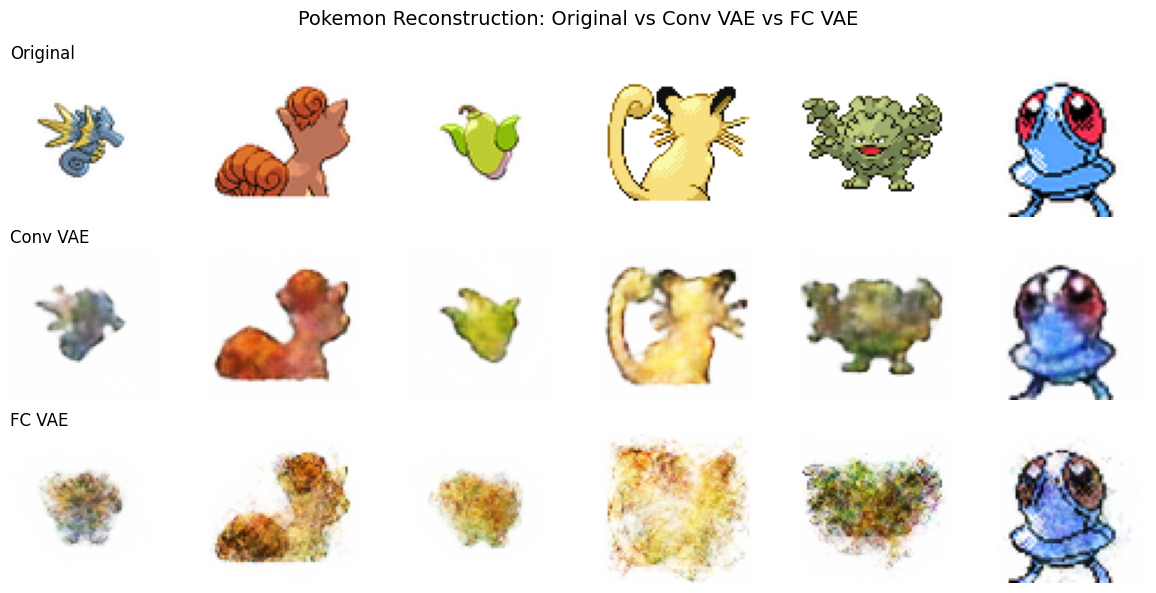

In [ ]:
# Now it's just the VAE building as before, but these images are 64x64

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Convolutional VAE for Pokemon (64x64 images)
class PokemonConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(PokemonConvVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder: 64x64 -> 32x32 -> 16x16 -> 8x8 -> 4x4
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),   # -> 32 x 32 x 32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # -> 64 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> 128 x 8 x 8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),# -> 256 x 4 x 4
            nn.ReLU(),
        )

        # Latent space projections
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

        # Decoder input
        self.fc_decode = nn.Linear(latent_dim, 256 * 4 * 4)

        # Decoder: 4x4 -> 8x8 -> 16x16 -> 32x32 -> 64x64
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # -> 128 x 8 x 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> 64 x 16 x 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # -> 32 x 32 x 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # -> 3 x 64 x 64
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(h.size(0), 256, 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Fully Connected VAE for Pokemon (for comparison)
class PokemonFCVAE(nn.Module):
    def __init__(self, input_dim=64*64*3, hidden_dim=1024, latent_dim=128):
        super(PokemonFCVAE, self).__init__()
        self.input_dim = input_dim

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 512)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        h = torch.relu(self.fc4(h))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        x_flat = x.view(x.size(0), -1)
        mu, logvar = self.encode(x_flat)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Loss function with KL annealing
def pokemon_vae_loss(recon_x, x, mu, logvar, beta=1.0):
    BCE = nn.functional.binary_cross_entropy(
        recon_x.view(recon_x.size(0), -1),
        x.view(x.size(0), -1),
        reduction='sum'
    )
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD


# Training function
def train_pokemon_vae(model, train_loader, optimizer, epoch, device, warmup_epochs=10):
    model.train()
    train_loss = 0
    beta = min(0.1, epoch / (warmup_epochs*10))

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = pokemon_vae_loss(recon_batch, data, mu, logvar, beta=beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Loss: {avg_loss:.4f}, Beta: {beta:.3f}')
    return avg_loss


# Initialize models
LATENT_DIM = 128
pokemon_conv_vae = PokemonConvVAE(latent_dim=LATENT_DIM).to(device)
pokemon_fc_vae = PokemonFCVAE(input_dim=IMAGE_SIZE*IMAGE_SIZE*3, latent_dim=LATENT_DIM).to(device)

# Optimizers
conv_optimizer = optim.Adam(pokemon_conv_vae.parameters(), lr=1e-3)
fc_optimizer = optim.Adam(pokemon_fc_vae.parameters(), lr=1e-3)

# Training
NUM_EPOCHS = 50  # Pokemon dataset is small, so we need more epochs

print("Training Convolutional VAE on Pokemon")
for epoch in range(1, NUM_EPOCHS + 1):
    train_pokemon_vae(pokemon_conv_vae, pokemon_loader, conv_optimizer, epoch, device)

print("\n" + "=" * 50)
print("Training Fully Connected VAE on Pokemon")
for epoch in range(1, NUM_EPOCHS + 1):
    train_pokemon_vae(pokemon_fc_vae, pokemon_loader, fc_optimizer, epoch, device)

print("\nTraining complete!")


# Show some reconstructions
def show_pokemon_reconstructions(conv_model, fc_model, data_loader, num_images=6):
    """Compare reconstruction quality between models."""
    conv_model.eval()
    fc_model.eval()

    images, labels = next(iter(data_loader))
    images = images[:num_images].to(device)

    with torch.no_grad():
        conv_recon, _, _ = conv_model(images)
        conv_recon = conv_recon.cpu()

        fc_recon, _, _ = fc_model(images)
        fc_recon = fc_recon.cpu().view(-1, 3, IMAGE_SIZE, IMAGE_SIZE)

    images = images.cpu()

    fig, axes = plt.subplots(3, num_images, figsize=(num_images * 2, 6))

    for i in range(num_images):
        # Original
        axes[0, i].imshow(images[i].permute(1, 2, 0).numpy())
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=12, loc='left')

        # Conv VAE
        axes[1, i].imshow(np.clip(conv_recon[i].permute(1, 2, 0).numpy(), 0, 1))
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Conv VAE', fontsize=12, loc='left')

        # FC VAE
        axes[2, i].imshow(np.clip(fc_recon[i].permute(1, 2, 0).numpy(), 0, 1))
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_title('FC VAE', fontsize=12, loc='left')

    plt.suptitle('Pokemon Reconstruction: Original vs Conv VAE vs FC VAE', fontsize=14)
    plt.tight_layout()
    plt.show()

show_pokemon_reconstructions(pokemon_conv_vae, pokemon_fc_vae, pokemon_loader)


Pokemon Interpolation Comparison


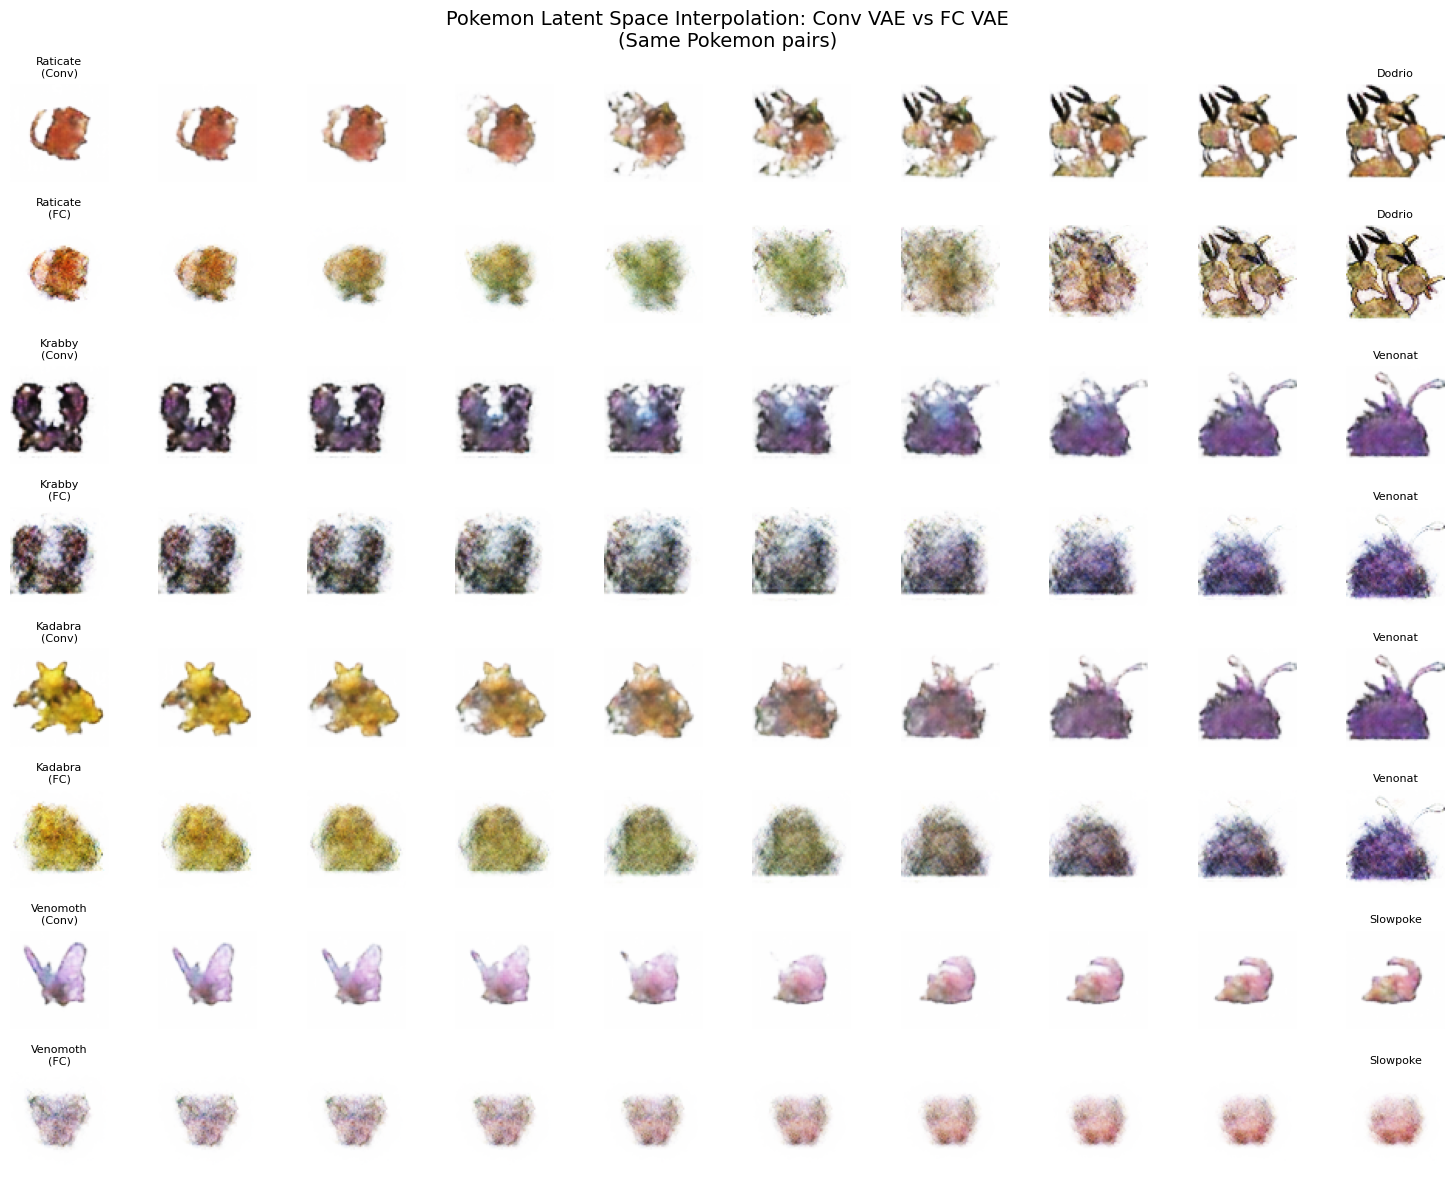

In [ ]:
def interpolate_pokemon(model, img1, img2, num_steps=10, device='cpu', flatten=False):
    """Interpolate between two Pokemon in latent space."""
    model.eval()

    with torch.no_grad():
        img1 = img1.unsqueeze(0).to(device)
        img2 = img2.unsqueeze(0).to(device)

        if flatten:
            img1_enc = img1.view(img1.size(0), -1)
            img2_enc = img2.view(img2.size(0), -1)
        else:
            img1_enc = img1
            img2_enc = img2

        mu1, _ = model.encode(img1_enc)
        mu2, _ = model.encode(img2_enc)

        interpolated = []
        for alpha in np.linspace(0, 1, num_steps):
            z_interp = (1 - alpha) * mu1 + alpha * mu2
            img_interp = model.decode(z_interp)
            interpolated.append(img_interp.cpu())

    return interpolated


def compare_pokemon_interpolations(conv_model, fc_model, dataset,
                                    num_pairs=3, num_steps=10, device='cpu'):
    """
    Compare interpolation between Conv VAE and FC VAE using the SAME Pokemon pairs.
    """
    conv_model.eval()
    fc_model.eval()

    # Get random pairs of Pokemon
    indices = np.random.choice(len(dataset), num_pairs * 2, replace=False)

    fig, axes = plt.subplots(num_pairs * 2, num_steps,
                             figsize=(num_steps * 1.5, num_pairs * 3))

    for pair_idx in range(num_pairs):
        idx1 = indices[pair_idx * 2]
        idx2 = indices[pair_idx * 2 + 1]

        img1, label1 = dataset[idx1]
        img2, label2 = dataset[idx2]

        name1 = dataset.get_name(label1)
        name2 = dataset.get_name(label2)

        # Interpolate with both models using SAME images
        conv_interp = interpolate_pokemon(conv_model, img1, img2, num_steps, device, flatten=False)
        fc_interp = interpolate_pokemon(fc_model, img1, img2, num_steps, device, flatten=True)

        conv_row = pair_idx * 2
        fc_row = pair_idx * 2 + 1

        # Display Conv VAE interpolation
        for step_idx, img in enumerate(conv_interp):
            img_np = img.squeeze(0).permute(1, 2, 0).numpy()
            axes[conv_row, step_idx].imshow(np.clip(img_np, 0, 1))
            axes[conv_row, step_idx].axis('off')

            if step_idx == 0:
                axes[conv_row, step_idx].set_title(f'{name1}\n(Conv)', fontsize=8)
            elif step_idx == num_steps - 1:
                axes[conv_row, step_idx].set_title(name2, fontsize=8)

        # Display FC VAE interpolation
        for step_idx, img in enumerate(fc_interp):
            img_np = img.view(3, IMAGE_SIZE, IMAGE_SIZE).permute(1, 2, 0).numpy()
            axes[fc_row, step_idx].imshow(np.clip(img_np, 0, 1))
            axes[fc_row, step_idx].axis('off')

            if step_idx == 0:
                axes[fc_row, step_idx].set_title(f'{name1}\n(FC)', fontsize=8)
            elif step_idx == num_steps - 1:
                axes[fc_row, step_idx].set_title(name2, fontsize=8)

    plt.suptitle('Pokemon Latent Space Interpolation: Conv VAE vs FC VAE\n(Same Pokemon pairs)',
                 fontsize=14)
    plt.tight_layout()
    plt.show()


# Run the interpolation comparison
print("=" * 50)
print("Pokemon Interpolation Comparison")
print("=" * 50)
compare_pokemon_interpolations(pokemon_conv_vae, pokemon_fc_vae, pokemon_dataset,
                                num_pairs=4, num_steps=10, device=device)




**Comments**

Ok, this is working better; I have loaded many more images from the dataset--instead of 151 original images, I have loaded 50-70 variants as available. I had worried that changes in images might harm the results, but the VAE did a better job of leaning "pokemon-ness" of images. I made one significant change, though. My KL is scaled down, allowing the model to learn reconstruction significantly better. KL penalty is applied at 10% instead of 100%. This will probably scatter the distribution a bit for sampling "random pokemon" but it has produced significantly better interpolation results...

 Sampling from Different Regions (Scales)
Generating samples from N(0, sigma) for sigma = 0.5, 1.0, 1.5, 2.0, 2.5


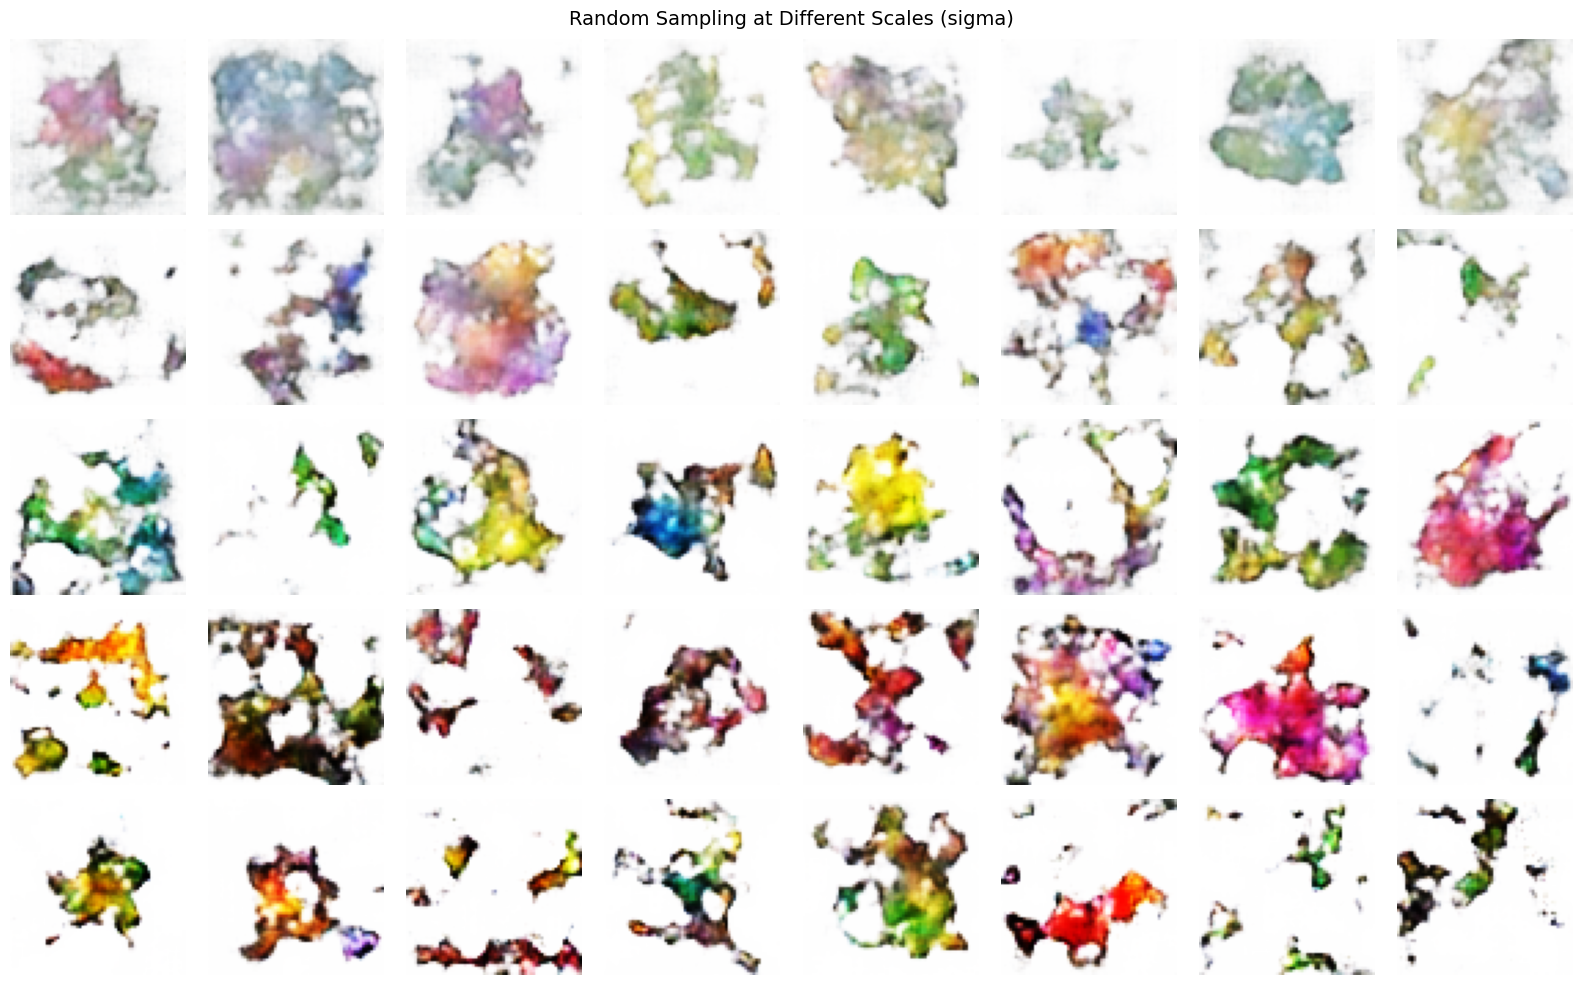


Observations:
- sigma = 0.5: Samples near the center tend to be more 'average' looking
- sigma = 1.0: Standard sampling matching the training prior
- sigma > 1.0: Moving further out may show more extreme features or artifacts


In [ ]:
# Sampling from Different Regions

def sample_at_different_scales(model, latent_dim, scales, num_samples_per_scale, device):
    """
    Generate images by sampling from N(0, sigma) for different sigma values.

    Args:
        model: Trained VAE with decode() method
        latent_dim: Dimension of latent space
        scales: List of sigma values to sample at
        num_samples_per_scale: Number of samples per scale
        device: torch device

    Returns:
        Dictionary mapping scale -> generated images tensor
    """
    model.eval()
    results = {}

    with torch.no_grad():
        for scale in scales:
            # Sample z from N(0, sigma) = sigma * N(0, 1)
            z = torch.randn(num_samples_per_scale, latent_dim).to(device) * scale
            images = model.decode(z).cpu()
            results[scale] = images

    return results


def visualize_scale_samples(results, scales):
    """
    Visualize samples from different scales in a grid.
    Rows = scales, Columns = samples
    """
    num_scales = len(scales)
    num_samples = results[scales[0]].shape[0]

    fig, axes = plt.subplots(num_scales, num_samples, figsize=(num_samples * 2, num_scales * 2))

    for row, scale in enumerate(scales):
        images = results[scale]
        for col in range(num_samples):
            img = images[col].permute(1, 2, 0).numpy()
            axes[row, col].imshow(np.clip(img, 0, 1))
            axes[row, col].axis('off')

            # Label the first column with the scale
            if col == 0:
                axes[row, col].set_ylabel(f'sigma = {scale}', fontsize=12, rotation=0,
                                          labelpad=40, va='center')

    plt.suptitle('Random Sampling at Different Scales (sigma)',
                 fontsize=14)
    plt.tight_layout()
    plt.show()


print(" Sampling from Different Regions (Scales)")
print("Generating samples from N(0, sigma) for sigma = 0.5, 1.0, 1.5, 2.0, 2.5")

scales = [0.5, 1.0, 1.5, 2.0, 2.5]
scale_results = sample_at_different_scales(
    pokemon_conv_vae,
    latent_dim=LATENT_DIM,
    scales=scales,
    num_samples_per_scale=8,
    device=device
)
visualize_scale_samples(scale_results, scales)

print("\nObservations:")
print("- sigma = 0.5: Samples near the center tend to be more 'average' looking")
print("- sigma = 1.0: Standard sampling matching the training prior")
print("- sigma > 1.0: Moving further out may show more extreme features or artifacts")

t-SNE Latent Space Visualization
Encoded 7978 sprites to 128-dimensional latent space


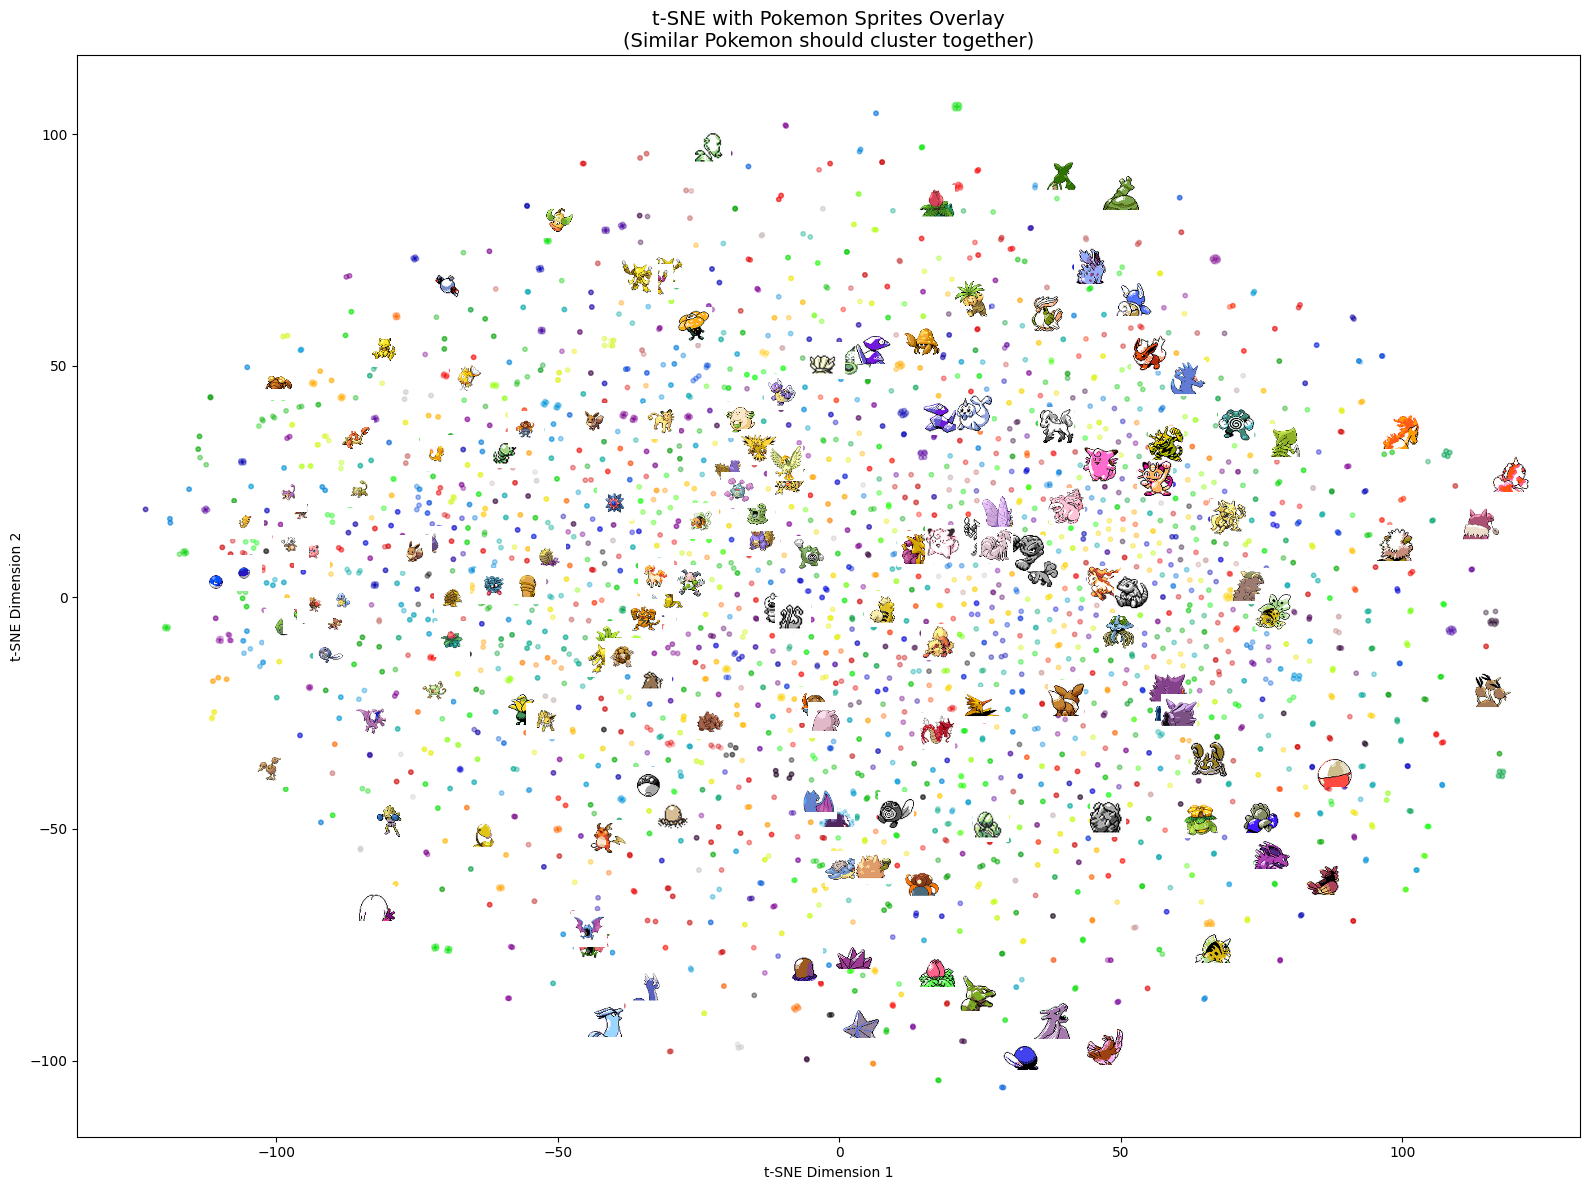

In [ ]:
# Analyze!
# Encode all Pokemon to latent space and visualize with t-SNE to see how
# the VAE organizes different Pokemon.

from sklearn.manifold import TSNE

def encode_dataset_to_latent(model, dataset, device):
    """
    Encode all images in dataset to latent space.
    Uses mu (mean) for deterministic embedding.

    Returns:
        mu_vectors: Tensor of shape (N, latent_dim)
        labels: List of Pokemon IDs
    """
    model.eval()
    all_mu = []
    all_labels = []

    with torch.no_grad():
        for idx in range(len(dataset)):
            img, label = dataset[idx]
            img = img.unsqueeze(0).to(device)
            mu, _ = model.encode(img)
            all_mu.append(mu.cpu())
            all_labels.append(label)

    return torch.cat(all_mu, dim=0), all_labels


def visualize_latent_with_sprites(coords, dataset, num_sprites=50, sprite_size=0.08):
    """
    Overlay sample Pokemon sprites on the t-SNE plot. We'll have to look for patterns manually here.
    """
    fig, ax = plt.subplots(figsize=(16, 12))

    # Plot all points faintly
    labels = [dataset.labels[i] for i in range(len(dataset))]
    ax.scatter(coords[:, 0], coords[:, 1], c=labels, cmap='nipy_spectral',
               alpha=0.2, s=10)

    # Overlay random sprites
    indices = np.random.choice(len(dataset), min(num_sprites, len(dataset)), replace=False)

    # Calculate axis ranges for proper sprite sizing
    x_range = coords[:, 0].max() - coords[:, 0].min()
    y_range = coords[:, 1].max() - coords[:, 1].min()

    from matplotlib.offsetbox import OffsetImage, AnnotationBbox

    for idx in indices:
        img, label = dataset[idx]
        img_np = img.permute(1, 2, 0).numpy()

        # Create small image for overlay
        imagebox = OffsetImage(np.clip(img_np, 0, 1), zoom=0.4)
        ab = AnnotationBbox(imagebox, (coords[idx, 0], coords[idx, 1]),
                           frameon=False, pad=0)
        ax.add_artist(ab)

    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.set_title('t-SNE with Pokemon Sprites Overlay\n'
                 '(Similar Pokemon should cluster together)', fontsize=14)
    plt.tight_layout()
    plt.show()


print("t-SNE Latent Space Visualization")

# Encode all Pokemon sprites to latent space
mu_vectors, labels = encode_dataset_to_latent(pokemon_conv_vae, pokemon_dataset, device)
print(f"Encoded {len(labels)} sprites to {mu_vectors.shape[1]}-dimensional latent space")


# Visualize with sprite overlays
visualize_latent_with_sprites(coords, pokemon_dataset, num_sprites=151)


Well. Hm.

Some patterns I'm seeing here:
- small pokemon are grouped with small, large with large. (See left to right)
- Roundish pokemon are nearer to roundish than to ones with features sticking out
- There's some similar-color groupings, but it's not universal

I think this is basically working, though. Despite the lowered KL (10% strength), there's a uniform round distribution, which was expected when we regularize towards N(0,I)